In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import retro_prepare_data
import matplotlib.colors

In [2]:
patient_id = 'id037_cg'
data_dir = f'datasets/retro/{patient_id}'
results_dir = f'results/exp10/exp10.67/{patient_id}'
szr_name = 'CG_C1_120213B-BEX_0001'
meta_data_fname = f'{szr_name}.json'
raw_seeg_fname = f'{szr_name}.raw.fif'
fname_suffix = f'{szr_name}'
# if os.path.isdir(results_dir):
#     os.rmdir(results_dir)
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)

In [3]:
hpf = 10
lpf = 0.02
data = retro_prepare_data.prepare_data(data_dir, meta_data_fname, raw_seeg_fname, hpf, lpf)
fname_suffix += f'_hpf{hpf}_lpf{lpf}'

Isotrak not found


In [4]:
ds_freq = int(data['slp'].shape[0]/150)
data['slp'] = data['slp'][0:-1:ds_freq]
data['snsr_pwr'] = (data['slp']**2).mean(axis=0)
data['ns'], data['nn'] = data['gain'].shape
data['nt'] = data['slp'].shape[0]
ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0]
data['x0_mu'] = -3.0*np.ones(data['nn'])
data['x0_mu'][ez_hyp] = -1.5

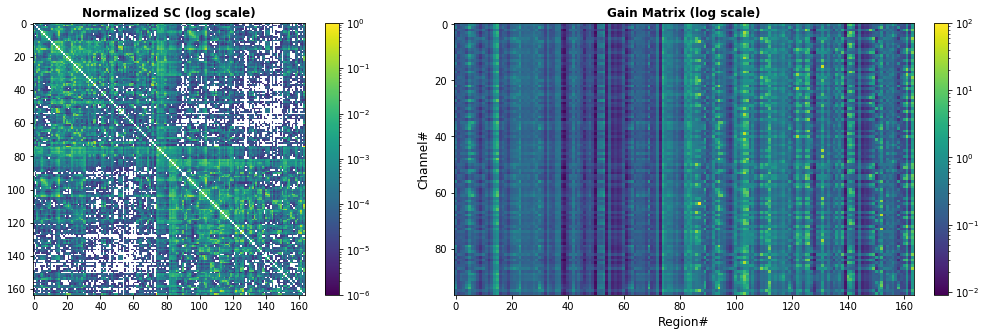

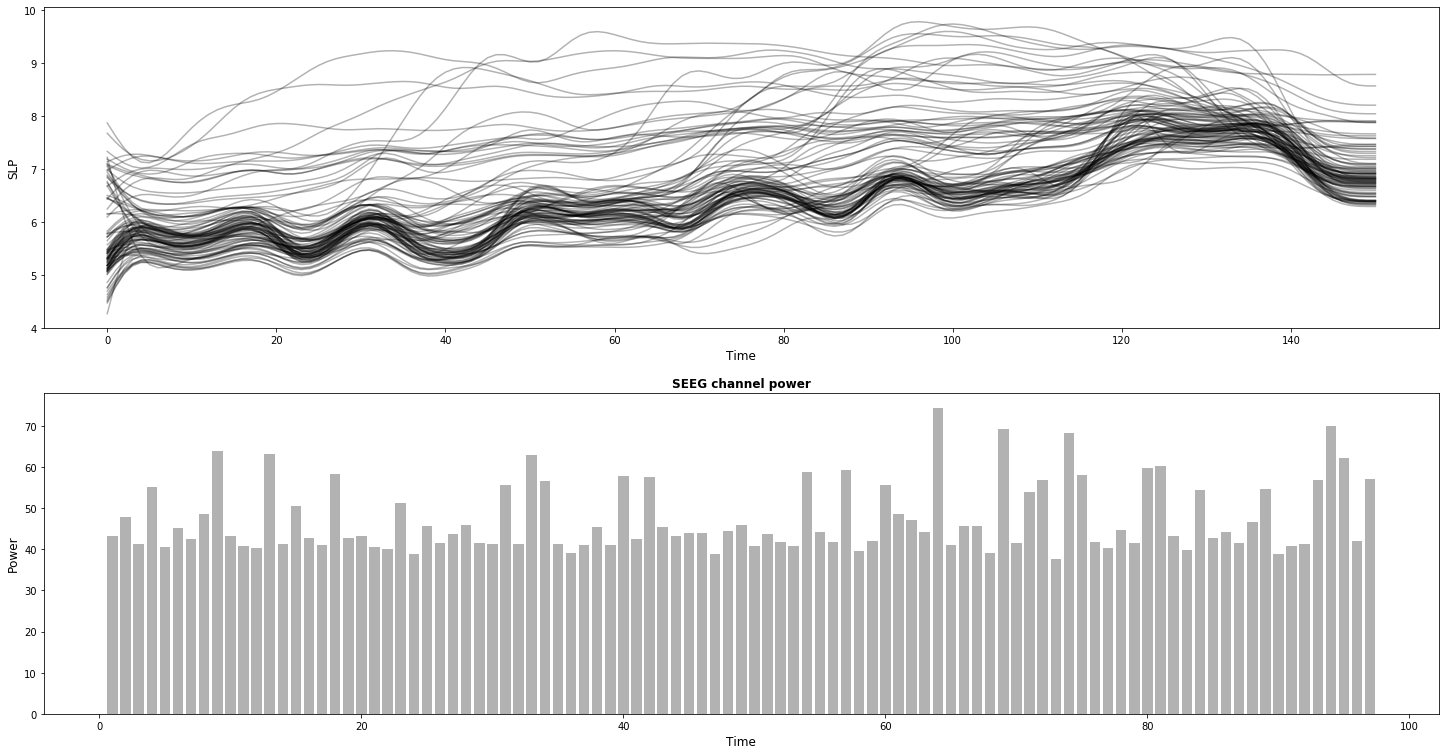

In [5]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(data['SC'],norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=data['SC'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.title('Normalized SC (log scale)',fontsize=12, fontweight='bold')

plt.subplot(122)
plt.imshow(data['gain'],norm=matplotlib.colors.LogNorm(vmin=data['gain'].min(), vmax=data['gain'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.xlabel('Region#', fontsize=12)
plt.ylabel('Channel#', fontsize=12)
plt.title('Gain Matrix (log scale)',fontsize=12, fontweight='bold')
plt.savefig(f'{results_dir}/figures/network.png')

plt.figure(figsize=(25,13))
plt.subplot(211)
plt.plot(data['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('SLP', fontsize=12)

plt.subplot(212)
plt.bar(np.r_[1:data['ns']+1],data['snsr_pwr'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('SEEG channel power', fontweight='bold')
plt.savefig(f'{results_dir}/figures/fitting_target_{fname_suffix}.png')
# plt.tight_layout()


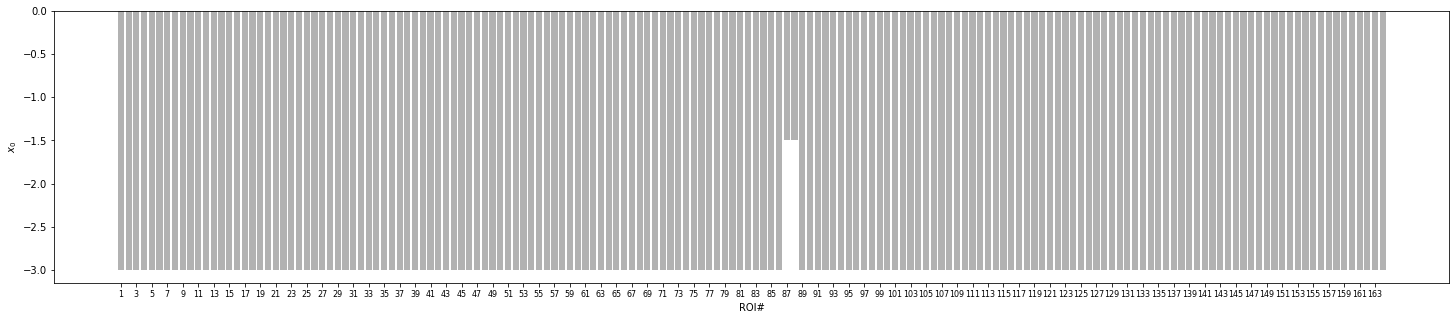

In [6]:
plt.figure(figsize=(25,5))
plt.bar(np.r_[1:data['nn']+1],data['x0_mu'], color='black', alpha=0.3)
plt.xticks(np.r_[1:data['nn']+1:2], fontsize=8);
plt.xlabel('ROI#')
plt.ylabel(r'$x_0$', fontsize=10)
plt.savefig(f'{results_dir}/figures/ez_hyp.png')

In [7]:
stan_fname = 'vep-snsrfit-ode-nointerp'


x0 = data['x0_mu']
amplitude = 1.0 
offset = 0
K = 1.0
tau0 = 20
eps_slp = 1.0
eps_snsr_pwr = 1.0
x_init = -2.0*np.ones(data['nn'])
z_init = 3.5*np.ones(data['nn'])

param_init = {'x0':x0, 'amplitude':amplitude,
              'offset':offset, 'K':K, 'tau0':tau0, 'x_init':x_init, 'z_init':z_init,
              'eps_slp':eps_slp, 'eps_snsr_pwr':eps_snsr_pwr}

param_init_file = 'param_init.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)

input_Rfile = f'fit_data_{fname_suffix}.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

In [8]:
%%bash -s "$stan_fname"
stancompile.sh $1

/home/anirudh/hdisk/Academia/projects/vep.stan
make: '/home/anirudh/hdisk/Academia/projects/vep.stan/vep-snsrfit-ode-nointerp' is up to date.


In [9]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4

#tol_obj=0 tol_rel_obj=0 tol_grad=0 tol_rel_grad=0 tol_param=0
for i in {1..4};
do
./${STAN_FNAME} optimize algorithm=lbfgs tol_param=1e-5 iter=20000 save_iterations=0  \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}_chain${i}.log &
done

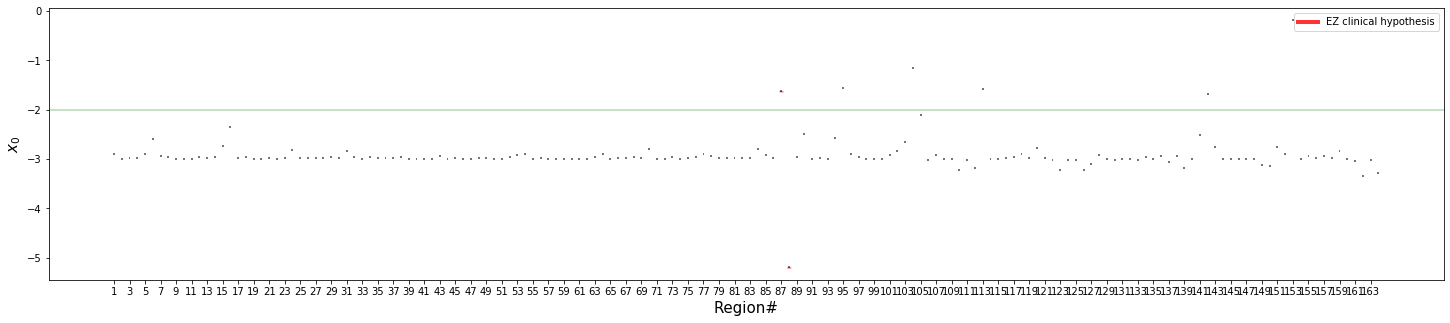

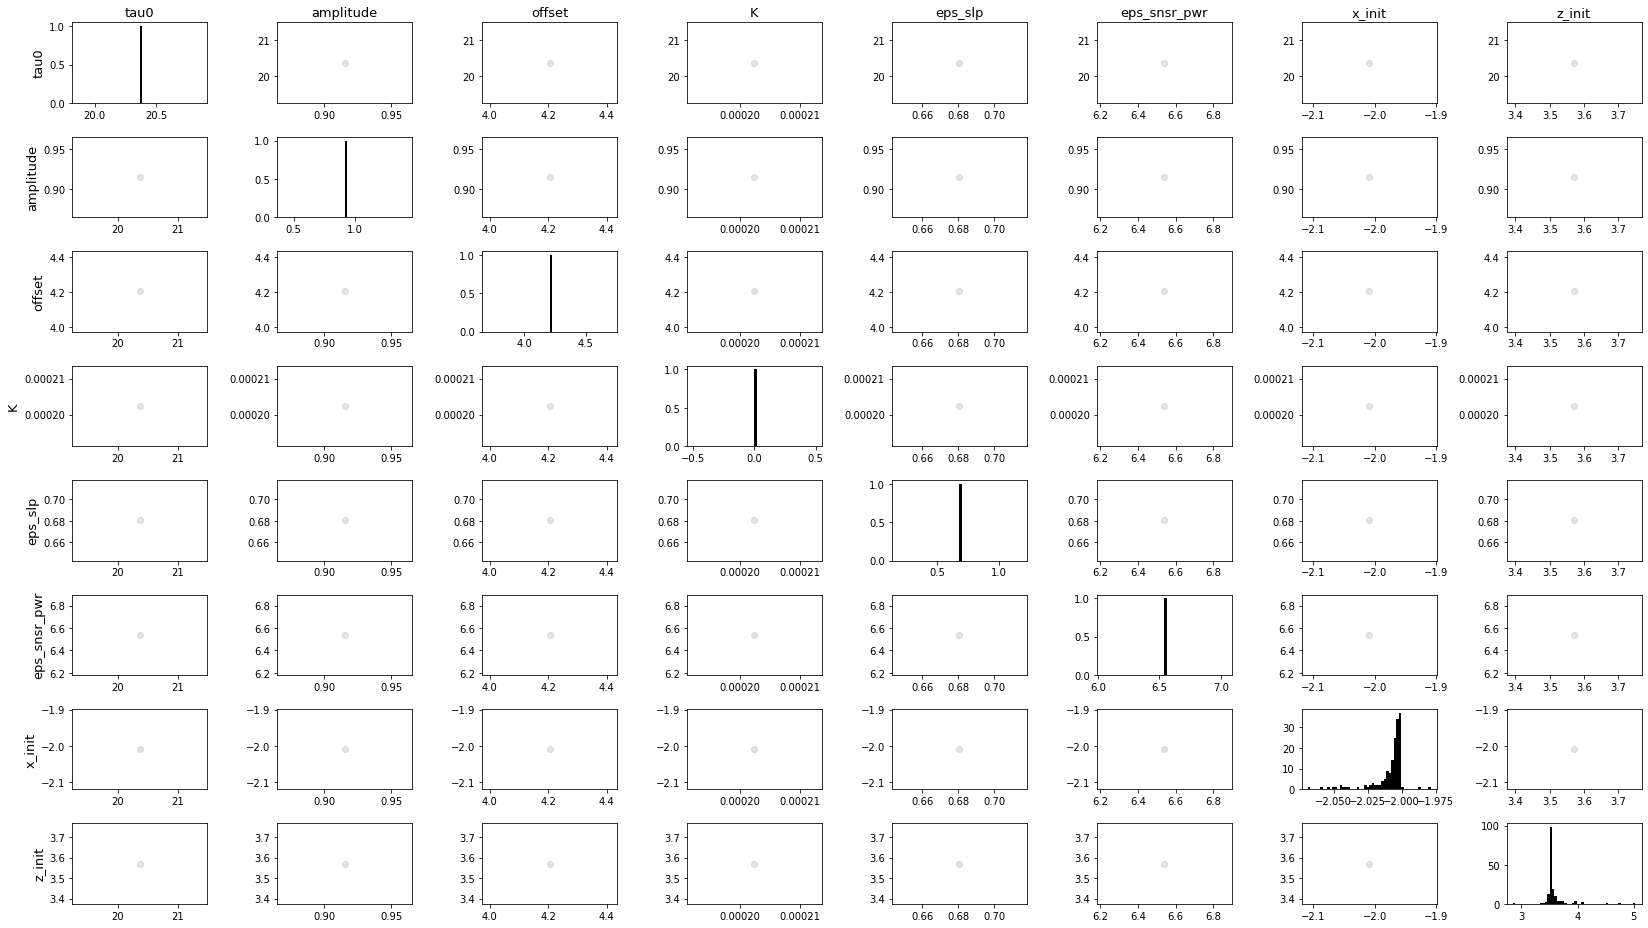

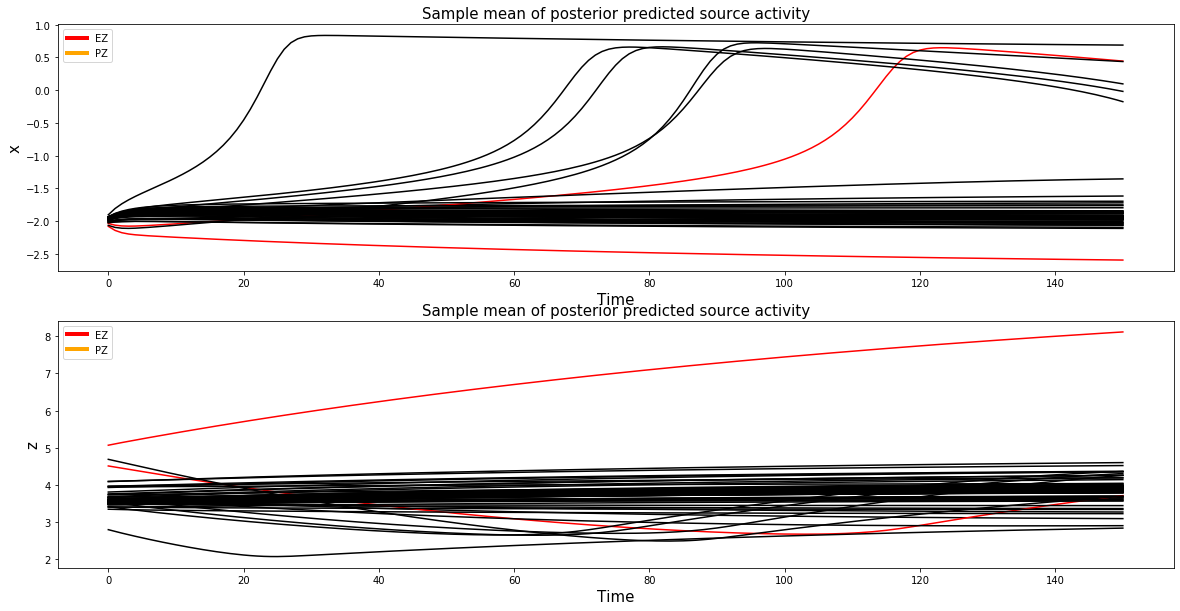

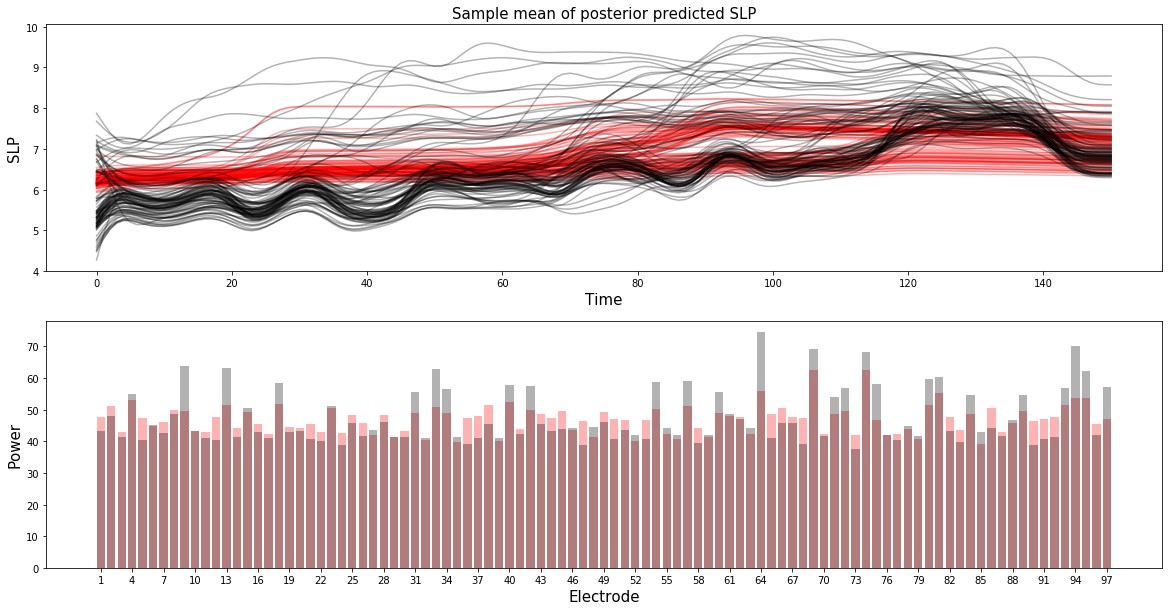

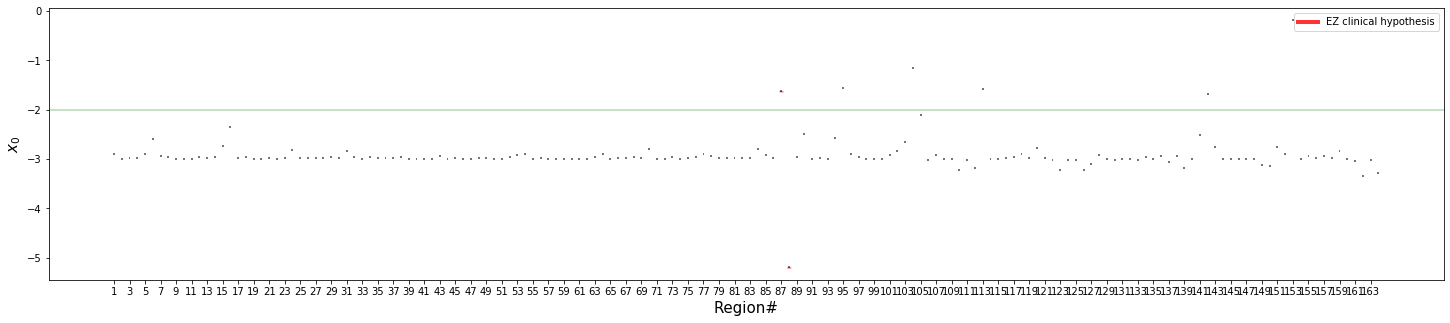

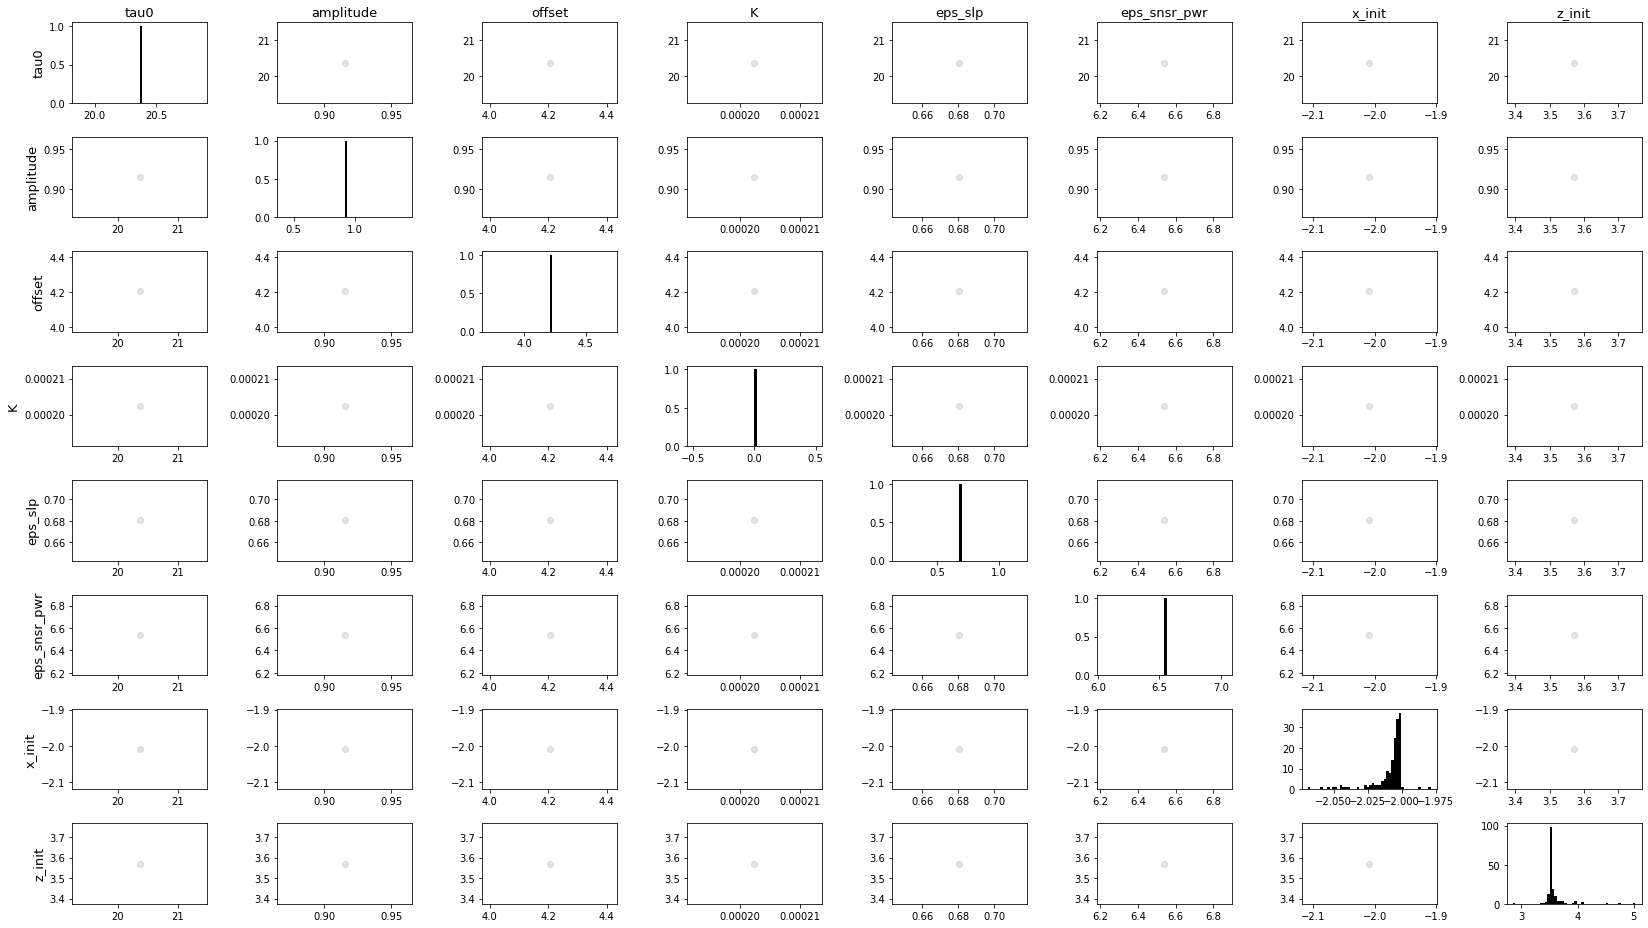

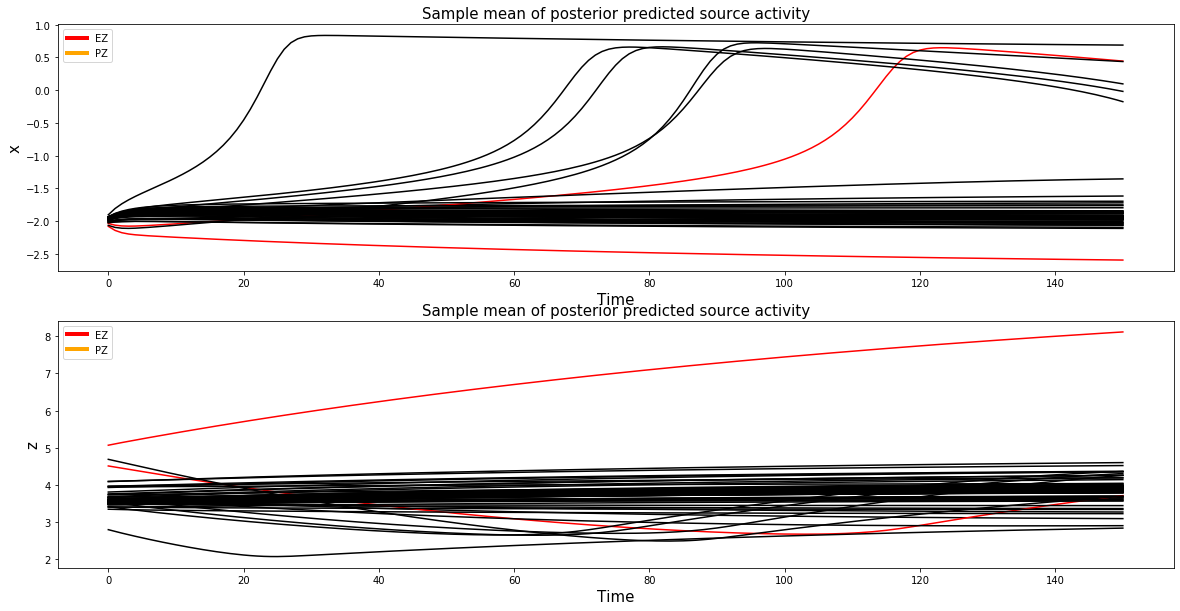

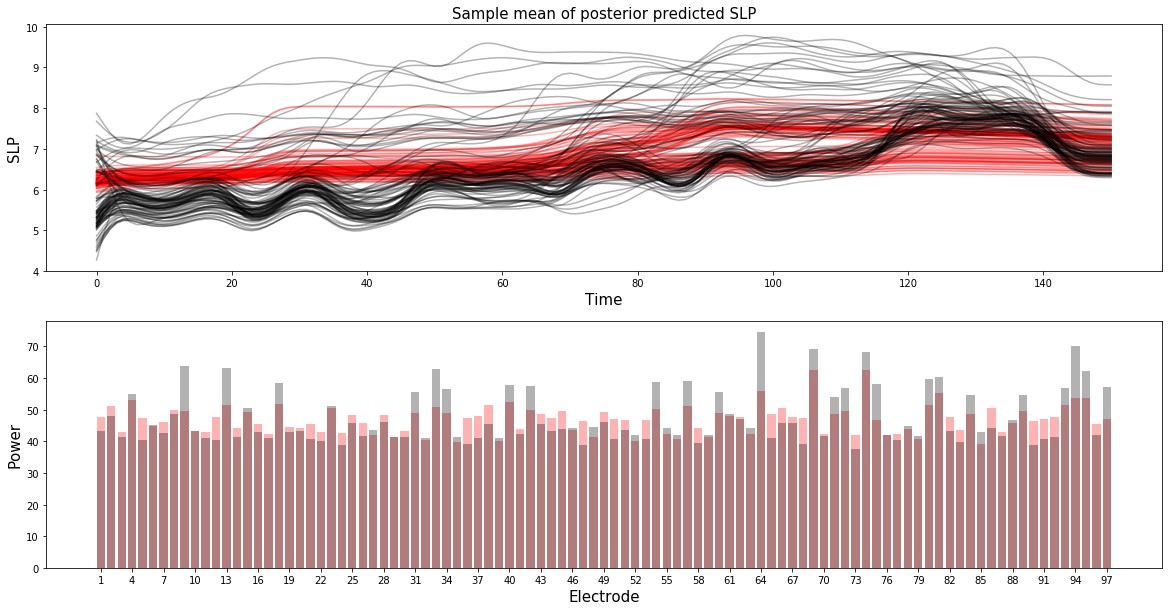

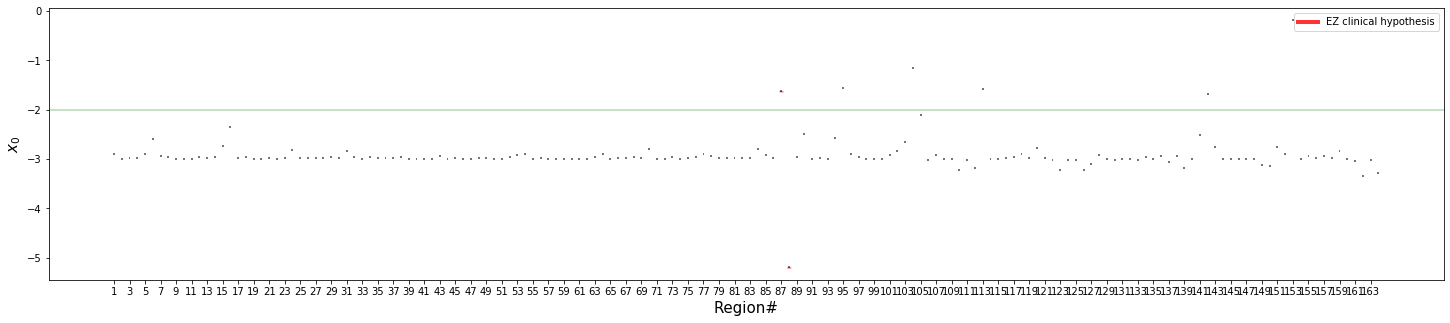

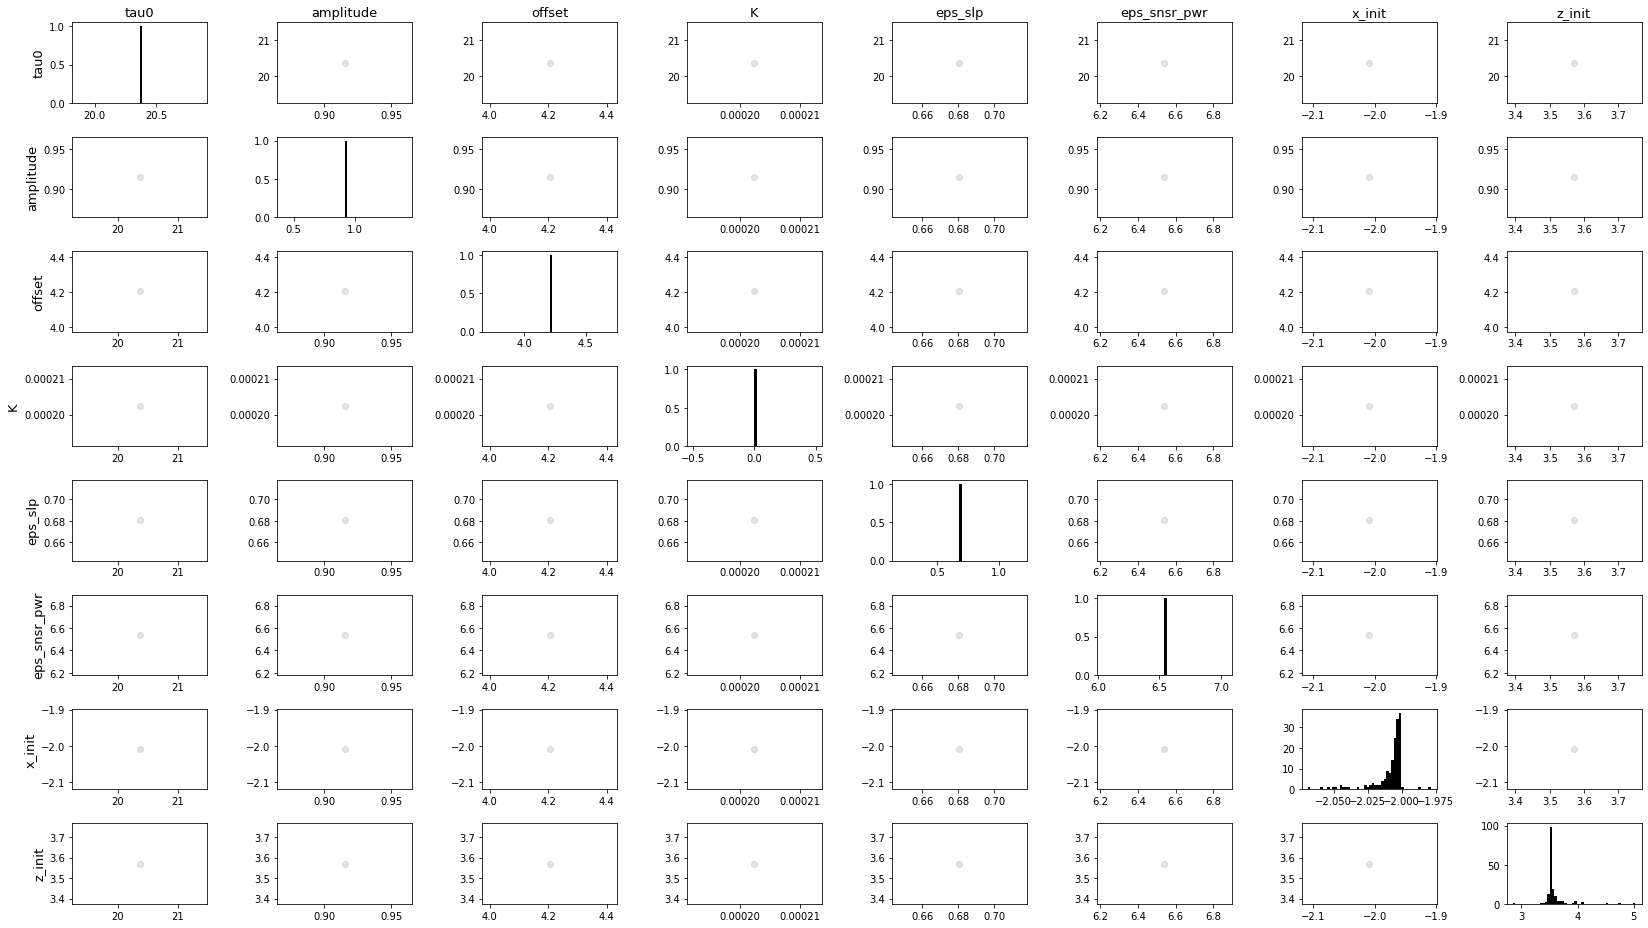

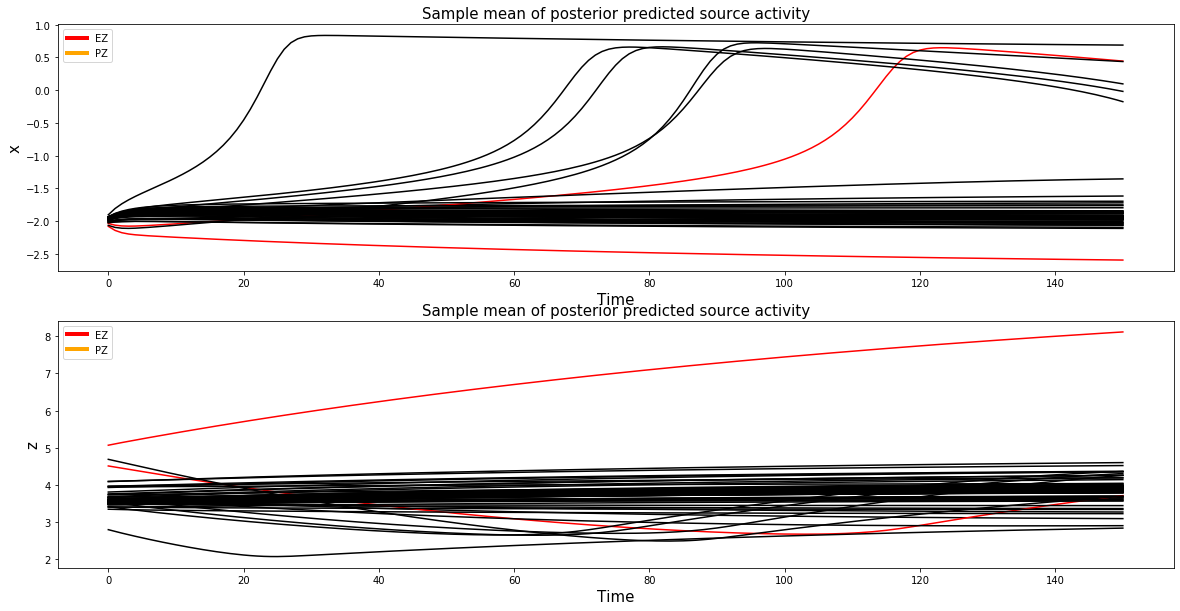

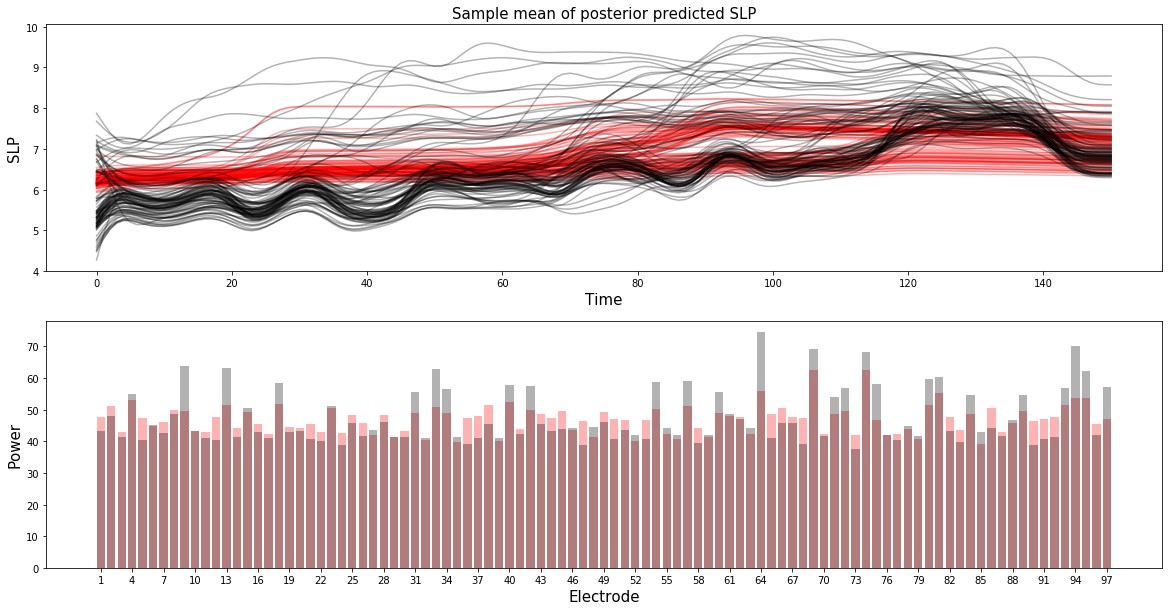

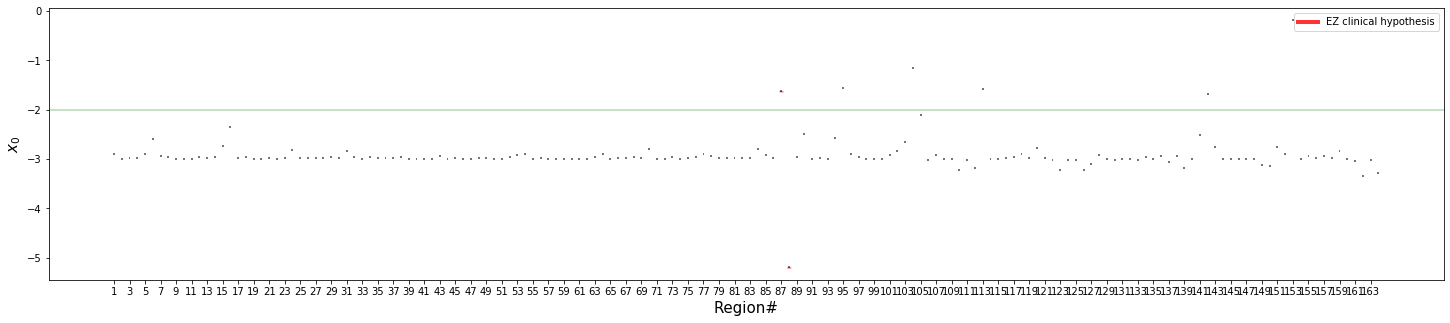

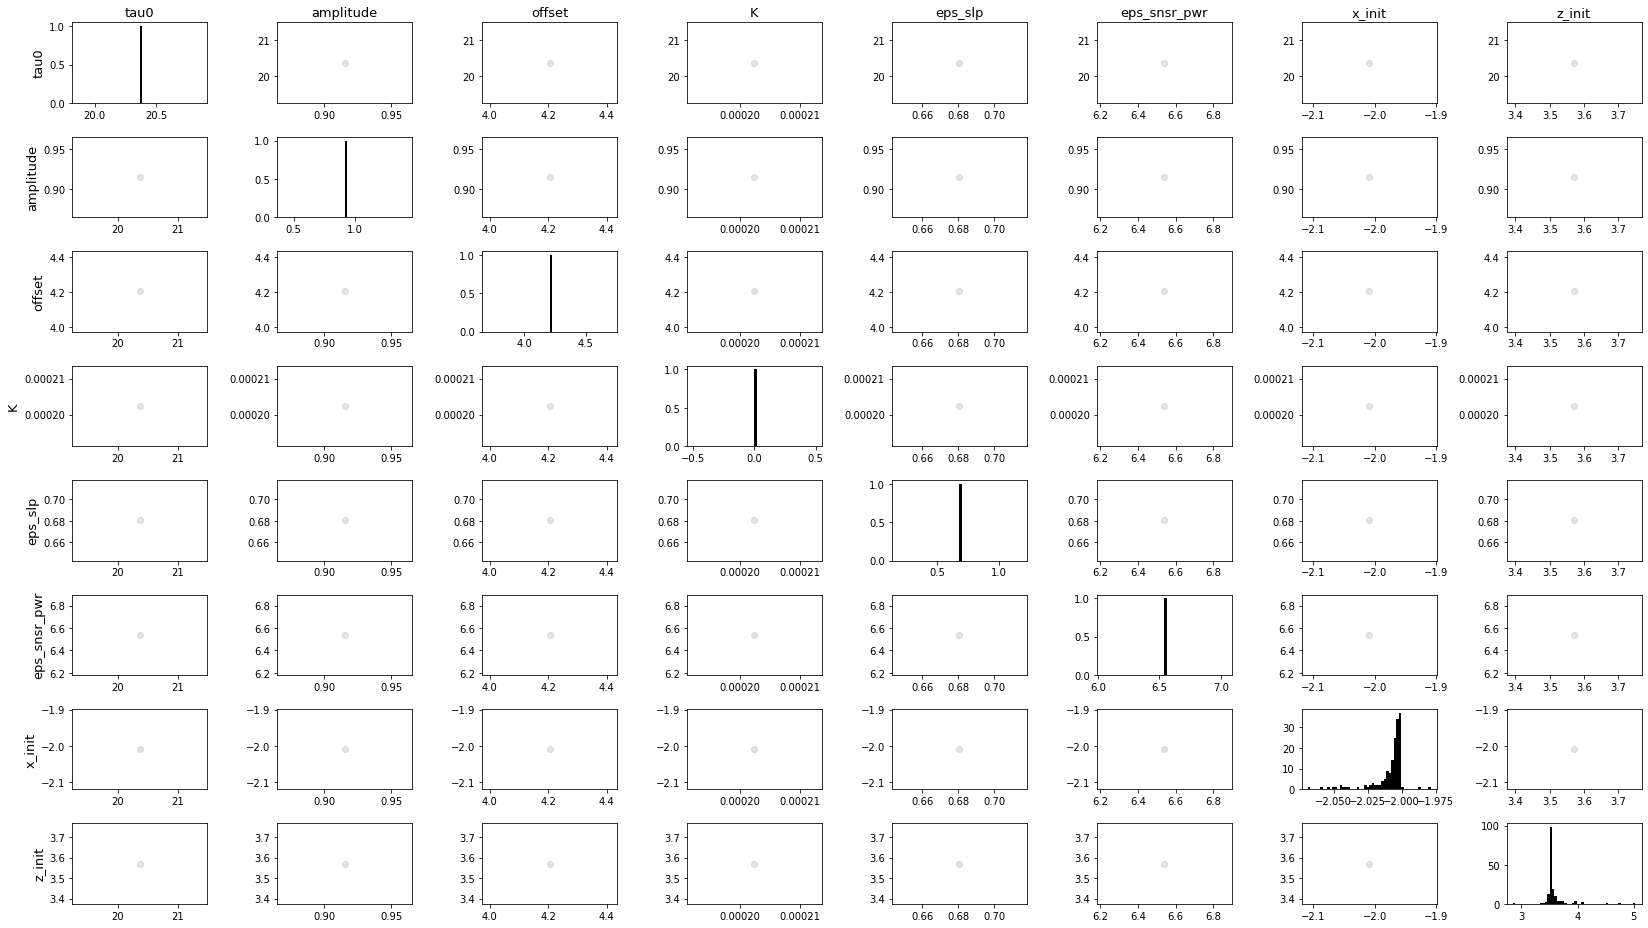

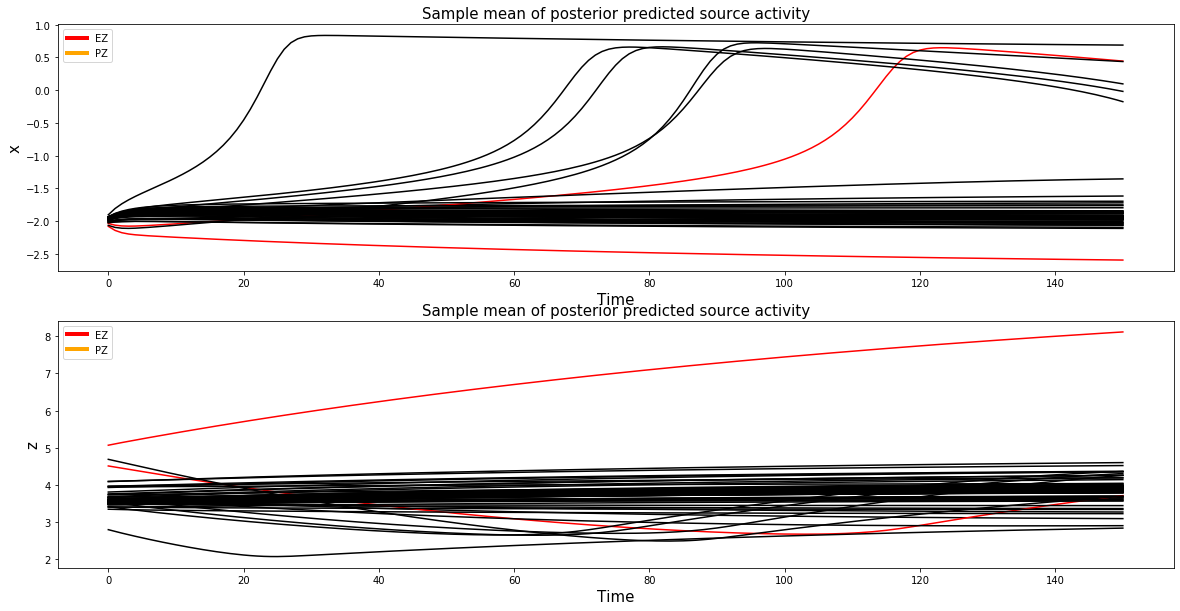

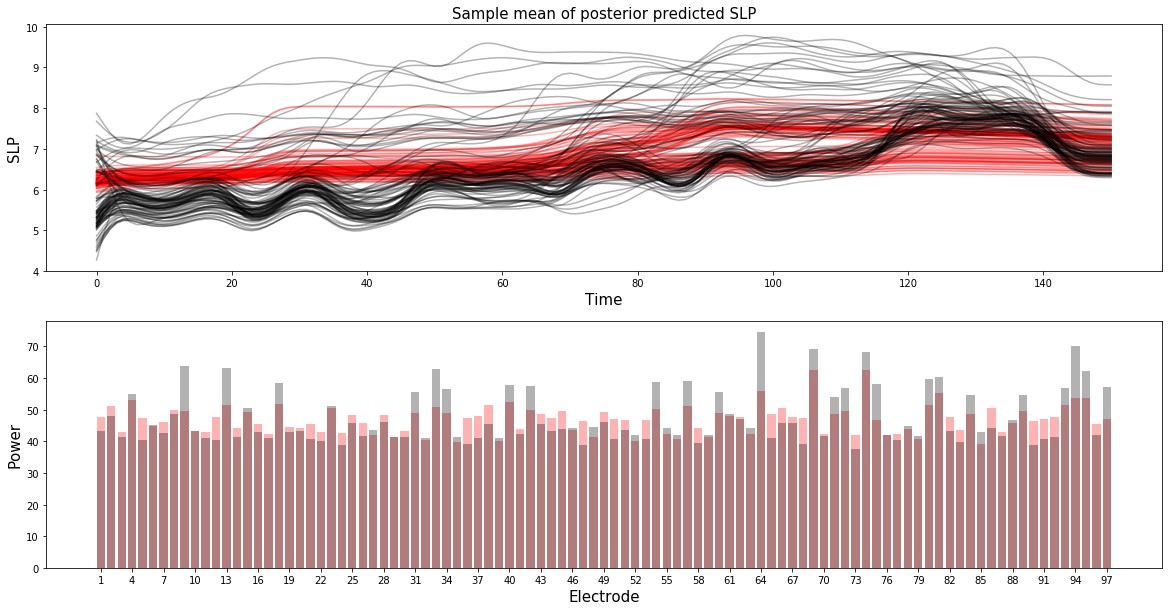

In [10]:
# import importlib
# importlib.reload(lib.plots.stan)

# ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0]
chains = [1,2,3,4]
for i,chain_no in enumerate(chains):
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'])
    lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ez_hyp, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.pair_plots(pstr_samples, ['tau0', 'amplitude', 'offset', 'K', 'eps_slp', 'eps_snsr_pwr', 'x_init', 'z_init'],
                              figname=f'{results_dir}/figures/params_pair_plots_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.plot_source(pstr_samples['x'].mean(axis=0), pstr_samples['z'].mean(axis=0), ez_hyp, [],
                               figname=f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.plot_fit_target({'slp':pstr_samples['mu_slp'].mean(axis=0), 'snsr_pwr':pstr_samples['mu_snsr_pwr'].mean(axis=0)},
                                   data, figname=f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}_chain{chain_no}.png')

